In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [37]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Jacob/Downloads/windows_10_msbuild_Release_graphviz-8.1.0-win32/Graphviz/bin'

In [38]:
def f(x):
    return 3*x**2 - 4*x +5
    

In [39]:
f(3)

20

In [40]:
f(3.0)

20.0

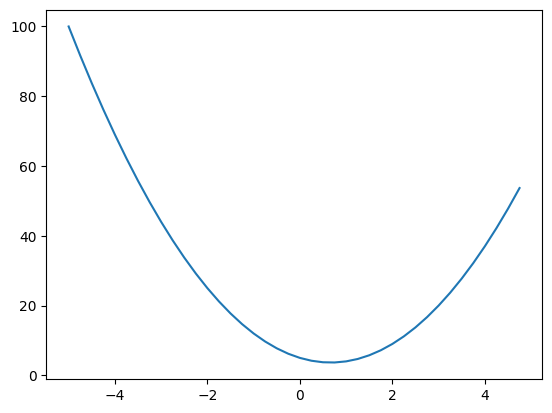

In [41]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [42]:
h=0.00000001
x=2/3
(f(x+h)-f(x))/h #slope, normalized by division

0.0

In [43]:
a=2.0
b=-3.0
c=10.0
d=a*b + c
print(d)

4.0


In [44]:
h=0.000001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b + c
c+=h
d2=a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.000000999999999
slope 0.9999999992515995


In [173]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        # return f"{self.data}"
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}') 

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other): # equivalent to self / other
        return self * other**-1

    

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

# a=Value(2.0, label ='a')
# b=Value(-3.0, label='b')
# c=Value(10.0, label='c')

# e = a*b; e.label = 'e'
# d = e+c; d.label = 'd'
# f = Value(-2.0); f.label = 'f'
# L = d*f; L.label= 'L'
# L
#python will call a.__add__(b), where b is represented as "other"

In [140]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [46]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [47]:
d._op

'+'

In [48]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

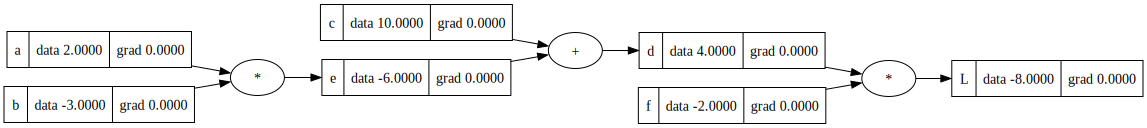

In [49]:
draw_dot(L)


In [50]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [51]:
e = a*b
d = e+c
L = d*f
print(L.data)

-8.0


In [52]:
c.grad = -2
e.grad = -2
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0


In [53]:
L.grad = 1.0

In [54]:
f.grad = 4.0
d.grad = -2.0

In [55]:
def lol():
    h = 0.001
    
    a=Value(2.0, label ='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0); f.label = 'f'
    L = d*f; L.label= 'L'
    L1 = L.data

    a=Value(2.0, label ='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    b.data+=h
    e = a*b; e.label = 'e'
    
    d = e+c; d.label = 'd'
    
    f = Value(-2.0); f.label = 'f'
    L = d*f; L.label= 'L'
    L2 = L.data 

    print((L2-L1)/h)

lol()

-3.9999999999995595


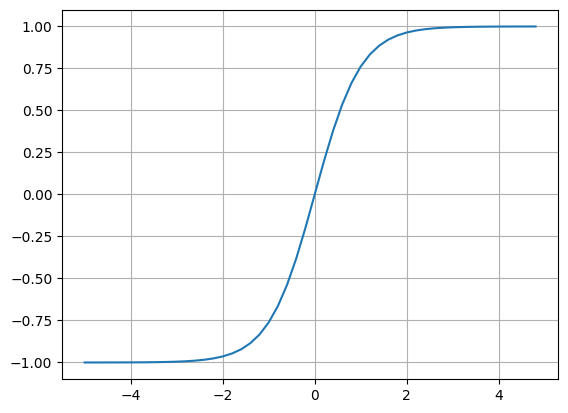

In [56]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [141]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'
o.backward()

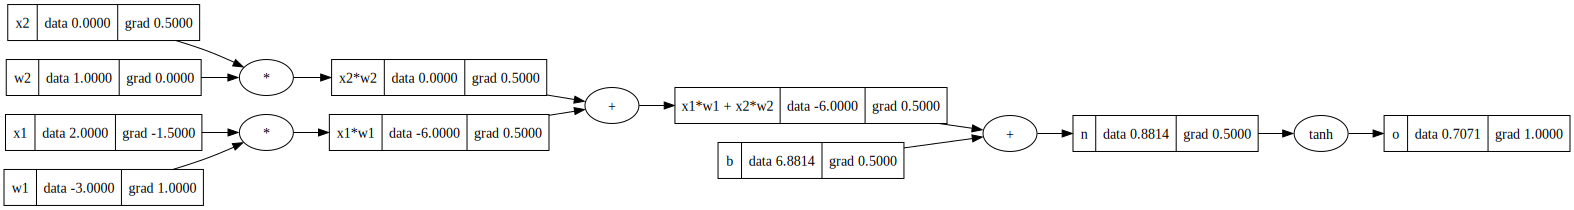

In [142]:
draw_dot(o)

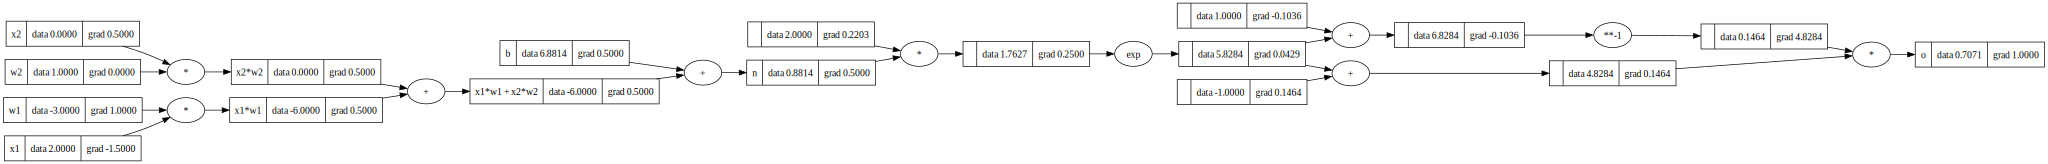

In [144]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1); o.label='o'
o.backward()
draw_dot(o)

In [110]:
o.backward()

In [107]:
o._backward()

In [85]:
n._backward()

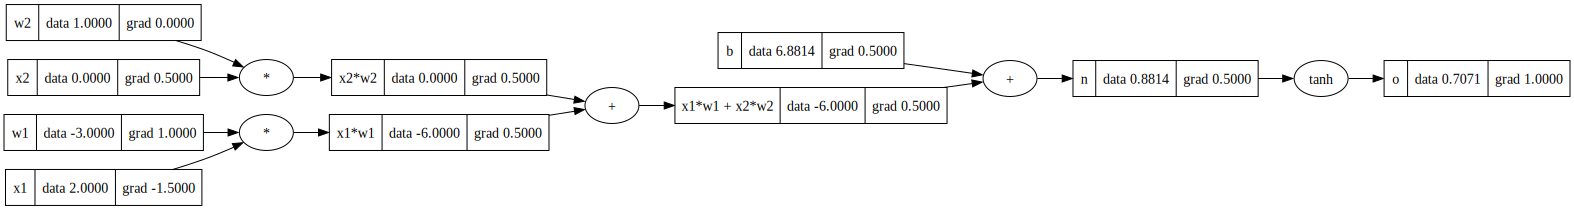

In [95]:
draw_dot(o)

In [63]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [65]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [60]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [96]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [93]:
x1w1._backward()

In [94]:
x2w2._backward()

In [88]:
b._backward()

In [90]:
x1w1x2w2._backward()

In [260]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [258]:
n.grad = 0.5

In [255]:
o.grad = 1.0

In [62]:
1-o.data**2

0.4999999999999999

In [1]:
# o = tanh(n)
#https://www.nsfwyoutube.com/watch?v=VMj-3S1tku0
#1:07:10

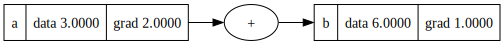

In [116]:
a = Value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

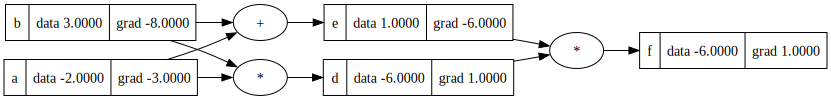

In [115]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [145]:
import torch

In [146]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [159]:
x2.grad.item()

0.5000001283844369

In [161]:
import random

In [209]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [366]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8580803757343601)

In [212]:
len(n.parameters())

41

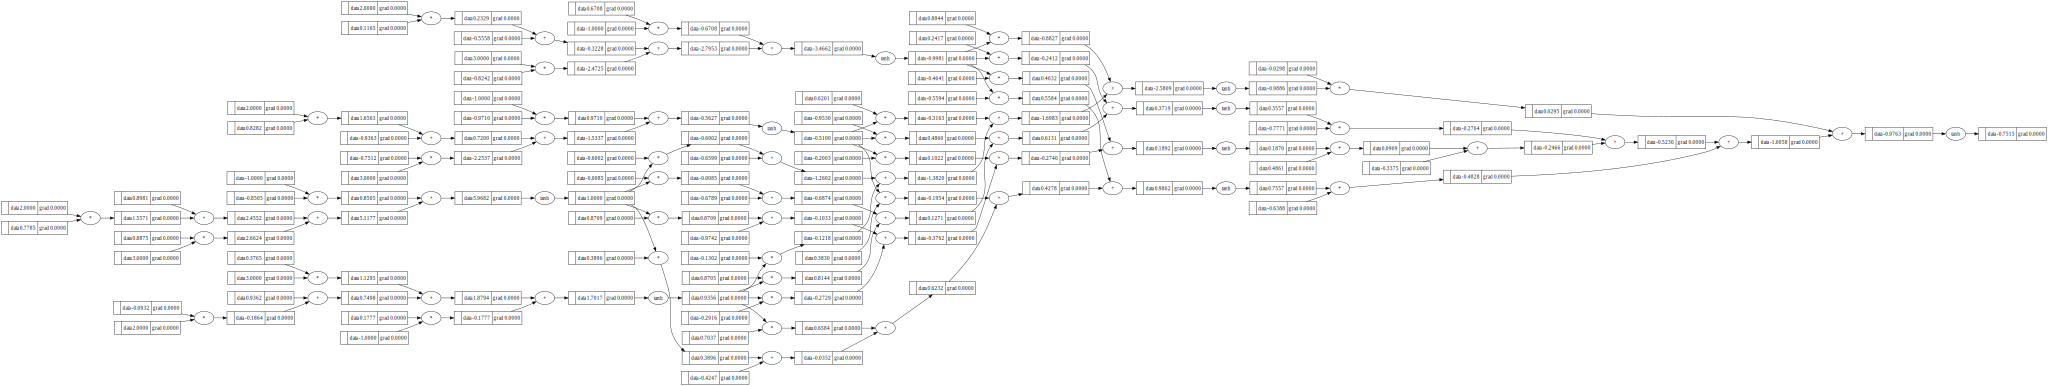

In [213]:
draw_dot(n(x))

In [367]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [378]:
for k in range(100000):
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    

    for p in n.parameters():
        p.data += -0.05 * p.grad 

    print(k, loss.data)

# forward pass, backward pass, update -> gradient descent; finding the local minimum for the loss function


0 0.00086480185128064
1 0.0008636790582283403
2 0.0008625591203457756
3 0.0008614420268547368
4 0.0008603277670309152
5 0.0008592163302035322
6 0.0008581077057550448
7 0.0008570018831207916
8 0.0008558988517886767
9 0.0008547986012988463
10 0.0008537011212433594
11 0.0008526064012658541
12 0.0008515144310612569
13 0.0008504252003754692
14 0.0008493386990050074
15 0.0008482549167967309
16 0.0008471738436475521
17 0.0008460954695040709
18 0.0008450197843623099
19 0.0008439467782674261
20 0.0008428764413133509
21 0.0008418087636425792
22 0.0008407437354457893
23 0.0008396813469615958
24 0.0008386215884762428
25 0.0008375644503233433
26 0.0008365099228835343
27 0.0008354579965842597
28 0.0008344086618994309
29 0.0008333619093491945
30 0.0008323177294996062
31 0.0008312761129623727
32 0.0008302370503946036
33 0.000829200532498506
34 0.0008281665500211109
35 0.000827135093754014
36 0.0008261061545331449
37 0.0008250797232384342
38 0.000824055790793599
39 0.0008230343481658548
40 0.0008220153

KeyboardInterrupt: 

In [357]:
loss.backward()

In [358]:
for p in n.parameters():
    p.data += -0.001 * p.grad 

In [377]:
ypred

[Value(data=0.9889388942859585),
 Value(data=-0.9825616957492475),
 Value(data=-0.9882084991627906),
 Value(data=0.9826666361146431)]

In [360]:
n.parameters()

[Value(data=-1.0948279127354836),
 Value(data=-0.5916724324505548),
 Value(data=-2.85605821883101),
 Value(data=-1.2345962511955957),
 Value(data=2.6951384850344695),
 Value(data=-9.324823464282359),
 Value(data=7.806804150565274),
 Value(data=1.352221603870158),
 Value(data=4.203621501122431),
 Value(data=3.4525612184967174),
 Value(data=-3.6677883346615707),
 Value(data=1.168186519510862),
 Value(data=1.1828775977203962),
 Value(data=-6.789696688294808),
 Value(data=10.756388675557794),
 Value(data=3.1331472799854065),
 Value(data=0.8105493071617634),
 Value(data=-2.404684566963373),
 Value(data=8.452774857415305),
 Value(data=-7.8320499010148925),
 Value(data=-2.2927950623667677),
 Value(data=3.8589330655117897),
 Value(data=5.8575116118387065),
 Value(data=-6.564743573383982),
 Value(data=5.121699199642002),
 Value(data=4.50620019411322),
 Value(data=5.036342338931325),
 Value(data=4.837374832768138),
 Value(data=-0.9193352419648744),
 Value(data=2.329216550783614),
 Value(data=4.9